### Example Commands
#### ER
python utils/main.py --model er --dataset seq-cifar100 --n_epochs 50 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 5000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift 5 --drift_severity 5 --drift_adaptation 0 --n_drifts 4

In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import glob

# Functions

In [2]:
def read_results(path):
    with open(path, "r") as jsonfile:
        data = json.load(jsonfile)

    accuracy_array = data["task_accuracies"]
    max_len = 0
    for task_accuracy in accuracy_array:
        if len(task_accuracy) > max_len:
            max_len = len(task_accuracy)

    for task_accuracy in accuracy_array:
        for i in range(max_len - len(task_accuracy)):
            task_accuracy.append(0.0)

    accuracy_array = np.array(accuracy_array)
    accuracy_array[accuracy_array == 0.0] = np.nan

    for i, acc_array in enumerate(accuracy_array):
        for j in range(len(acc_array)):
            if i > 0 and np.isnan(acc_array[j]) and not np.isnan(accuracy_array[i - 1][j]):
                accuracy_array[i][j] = 0.0

    return accuracy_array

In [3]:
def average_forgetting(accuracy_arrays):
    T = accuracy_arrays.shape[0]  # Total number of tasks
    forgetting = []

    for t in range(T - 1):
        max_accuracy = np.nanmax(accuracy_arrays[:t + 1, t])
        final_accuracy = accuracy_arrays[T - 1, t]
        f_t = max_accuracy - final_accuracy
        forgetting.append(f_t)

    avg_forgetting = np.mean(forgetting) if forgetting else 0.0
    return forgetting, avg_forgetting

In [4]:
def cumulative_average_multiple_runs(pattern):
    cumulative_averages = []
    cumulative_forgetting = []
    log_files = glob.glob(pattern)
    if len(log_files) == 0:
        print("No files found")
        return 0
    print(f"{len(log_files)} files found")
    for i, log in enumerate(log_files):
        print(f"{i + 1}: {log}")
        task_accuracies = read_results(log)
        cum_avg = [np.nansum(task_accuracies[j]) / (j + 1) for j in range(len(task_accuracies))]
        cumulative_averages.append(cum_avg)
        _, avg_forgetting = average_forgetting(task_accuracies)
        cumulative_forgetting.append(avg_forgetting)
    print(f"FAA: {np.mean(cumulative_averages, axis=0)[-1]:.2f} ± {np.std(cumulative_averages, axis=0)[-1]:.2f}")
    print(f"Avg. Forgetting: {np.mean(cumulative_forgetting, axis=0):.2f} ± {np.std(cumulative_forgetting, axis=0):.2f}")

    return np.round(np.mean(cumulative_averages, axis=0), decimals=2).tolist()

In [5]:
def plot_results(accuracy_array, title="Accuracy over Tasks"):
    plt.figure(figsize=(12, 6))
    for i in range(len(accuracy_array)):
        plt.plot(
            range(1, len(accuracy_array) + 1),
            accuracy_array[:, i],
            "-o",
            label=f"Avg. Acc. After T{i + 1}: {np.nansum(accuracy_array[i])/(i+1):.2f}%",
        )
        for j, value in enumerate(accuracy_array[:, i]):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(12.5, 0),
                ha="center",
                fontsize=6
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_array) + 1))
    plt.yticks(list(range(0, 101, 5)))
    plt.legend(prop={"size": 6}, loc="lower left")

In [6]:
def plot_cumulative_results(title, accuracy_arrays, labels):

    assert len(accuracy_arrays) == len(
        labels
    ), "The number of accuracy arrays and labels must match."

    plt.figure(figsize=(12, 6))

    for idx, (cum_avg_acc, label) in enumerate(zip(accuracy_arrays, labels)):
        plt.plot(range(1, len(cum_avg_acc) + 1), cum_avg_acc, "--o" if idx == 0 else "-o", label=label)
        for j, value in enumerate(cum_avg_acc):
            plt.annotate(
                f"{value:.2f}",
                (j + 1, value),
                textcoords="offset points",
                xytext=(
                    0,
                    -14 if (idx % 2) == 0 else 10,
                ),
                ha="center",
                fontsize=6,
            )

    plt.xlabel("Task Trained On", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.grid(True, linewidth=0.3)
    plt.title(title, fontsize=14)
    plt.xticks(range(1, len(accuracy_arrays[0]) + 1))
    plt.yticks(list(range(0, 106, 5)))
    plt.legend(prop={"size": 12}, loc="lower left")
    plt.show()

In [7]:
def plot_cumulative_subplots(cumulative_averages, subtitles, labels, plot_filename=""):
    assert len(cumulative_averages) // 4 == len(
        subtitles
    ), "The number of methods and plot subtitles must match."

    colors = [
        "#1f77b4",
        "#d62728",
        "#ff7f0e",
        "#2ca02c",
    ]

    markers = ["--o", "-s", "-^", "-x"]

    fig, axes = plt.subplots(1, len(cumulative_averages) // 4, figsize=(10, 5))

    for i in range(len(cumulative_averages) // 4):
        for j in range(4):
            axes[i].plot(
                range(1, len(cumulative_averages[4 * i + j]) + 1),
                cumulative_averages[4 * i + j],
                markers[j],
                label=f"{labels[j]}",
                color=colors[j],
            )
            axes[i].grid(True, linewidth=0.3)
            axes[i].set_title(subtitles[i], fontsize=16)
            if i == 0: axes[i].legend(prop={"size": 12}, loc="upper right")
            axes[i].set_xticks(range(1, len(cumulative_averages[i]) + 1))
            axes[i].set_yticks(list(range(0, 81, 10)))

    fig.supxlabel("Task Trained On", fontsize=16)
    fig.supylabel("Accuracy (%)\n", fontsize=16)
    plt.tight_layout()
    if plot_filename != "" and len(plot_filename) > 0:
        plt.savefig(plot_filename, format="pdf", dpi=300)
    plt.show()

CIFAR100 10 Tasks, 10 Classes Per Task

# ResNet-152 Backbone Study

## ER Buffer 5000

### Accuracy Without Drift

In [18]:
resnet152_er_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-cifar100-er-buf-5000-drift-6-s-5-n-4-adaptation-0.json"
)

1 files found
1: ./rebuttal-logs/10-15-25-23-48-12-seq-cifar100-er-buf-5000-drift-6-s-5-n-4-adaptation-0.json
FAA: 16.80 ± 0.00
Avg. Forgetting: 52.17 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9

In [19]:
resnet152_er_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-0.json"
)

1 files found
1: ./rebuttal-logs/10-15-25-23-51-02-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-0.json
FAA: 9.37 ± 0.00
Avg. Forgetting: 60.71 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [21]:
resnet152_er_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)

1 files found
1: ./rebuttal-logs/10-16-25-01-44-20-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 19.28 ± 0.00
Avg. Forgetting: 48.98 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [22]:
resnet152_er_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)

1 files found
1: ./rebuttal-logs/10-15-25-23-58-09-seq-cifar100-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 19.56 ± 0.00
Avg. Forgetting: 50.53 ± 0.00


### Cumulative Plots

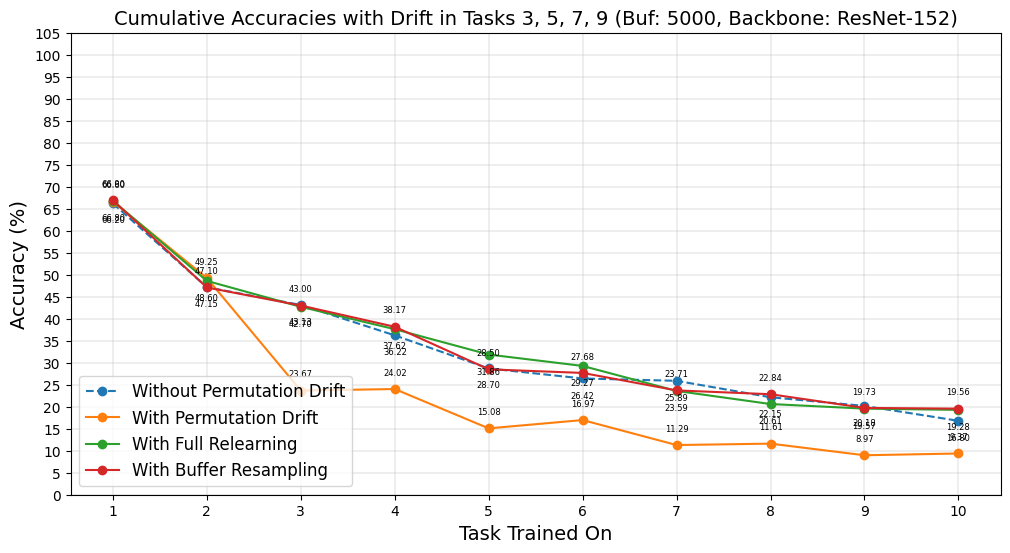

In [23]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000, Backbone: ResNet-152)",
    [
        resnet152_er_5000_accuracy_array_without_drift,
        resnet152_er_5000_accuracy_array_with_drift,
        resnet152_er_5000_accuracy_array_with_drift_full_relearning,
        resnet152_er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Full Relearning",
        "With Buffer Resampling",
    ],
)

# ViT-S Backbone Study

python utils/main.py --model er --dataset seq-cifar100-vit --n_epochs 100 --lr 0.1 --batch_size 32 --minibatch_size 32 --buffer_size 5000 --nowand 1 --non_verbose 1 --ignore_other_metrics 1 --seed 42 --concept_drift 6 --drift_severity 5 --drift_adaptation 0 --n_drifts 4

## ER Buffer 5000

### Accuracy Without Drift

In [13]:
ViT_S_er_5000_accuracy_array_without_drift = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-cifar100-vit-er-buf-5000-drift-6-s-5-n-4-adaptation-0.json"
)

1 files found
1: ./rebuttal-logs/10-23-25-17-17-25-seq-cifar100-vit-er-buf-5000-drift-6-s-5-n-4-adaptation-0.json
FAA: 17.53 ± 0.00
Avg. Forgetting: 45.94 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9

In [14]:
ViT_S_er_5000_accuracy_array_with_drift = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-cifar100-vit-er-buf-5000-drift-5-s-5-n-4-adaptation-0.json"
)

1 files found
1: ./rebuttal-logs/10-23-25-17-22-21-seq-cifar100-vit-er-buf-5000-drift-5-s-5-n-4-adaptation-0.json
FAA: 9.15 ± 0.00
Avg. Forgetting: 54.69 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9 with Full Relearning

In [15]:
ViT_S_er_5000_accuracy_array_with_drift_full_relearning = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-cifar100-vit-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json"
)

1 files found
1: ./rebuttal-logs/10-23-25-20-08-26-seq-cifar100-vit-er-buf-5000-drift-5-s-5-n-4-adaptation-1.json
FAA: 19.86 ± 0.00
Avg. Forgetting: 44.14 ± 0.00


### With Permutation Drift in Tasks 3, 5, 7, 9 with Buffer Resampling

In [16]:
ViT_S_er_5000_accuracy_array_with_drift_buffer_resampling = cumulative_average_multiple_runs(
    "./rebuttal-logs/*-seq-cifar100-vit-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json"
)

1 files found
1: ./rebuttal-logs/10-23-25-17-32-39-seq-cifar100-vit-er-buf-5000-drift-5-s-5-n-4-adaptation-2.json
FAA: 20.37 ± 0.00
Avg. Forgetting: 47.48 ± 0.00


### Cumulative Plots

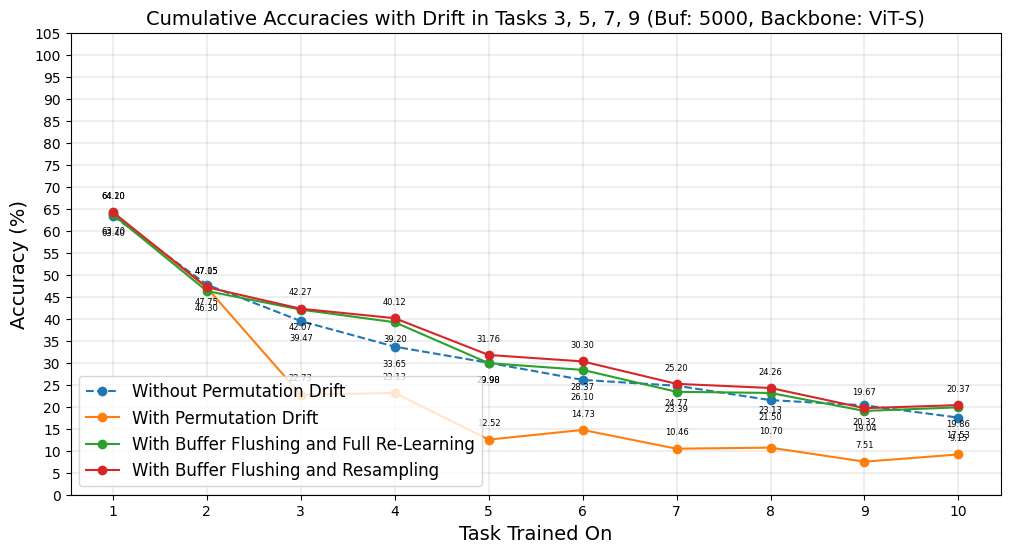

In [17]:
plot_cumulative_results(
    "Cumulative Accuracies with Drift in Tasks 3, 5, 7, 9 (Buf: 5000, Backbone: ViT-S)",
    [
        ViT_S_er_5000_accuracy_array_without_drift,
        ViT_S_er_5000_accuracy_array_with_drift,
        ViT_S_er_5000_accuracy_array_with_drift_full_relearning,
        ViT_S_er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    [
        "Without Permutation Drift",
        "With Permutation Drift",
        "With Buffer Flushing and Full Re-Learning",
        "With Buffer Flushing and Resampling",
    ],
)

# Comparisons

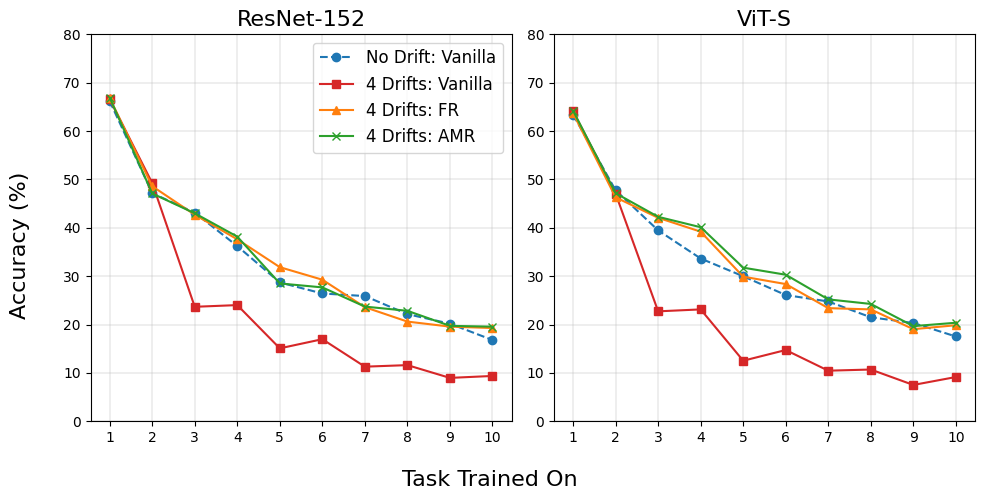

In [ ]:
plot_cumulative_subplots(
    [
        resnet152_er_5000_accuracy_array_without_drift,
        resnet152_er_5000_accuracy_array_with_drift,
        resnet152_er_5000_accuracy_array_with_drift_full_relearning,
        resnet152_er_5000_accuracy_array_with_drift_buffer_resampling,
        ViT_S_er_5000_accuracy_array_without_drift,
        ViT_S_er_5000_accuracy_array_with_drift,
        ViT_S_er_5000_accuracy_array_with_drift_full_relearning,
        ViT_S_er_5000_accuracy_array_with_drift_buffer_resampling,
    ],
    ["ResNet-152", "ViT-S"],
    [
        "No Drift: Vanilla",
        "4 Drifts: Vanilla",
        "4 Drifts: FR",
        "4 Drifts: AMR",
    ],
    # plot_filename="CIFAR100_Buff_5000_n_4_backbone_comparison.pdf",
)